# K-core (Africa)
### Understanding influence of big networks in Africa

In [9]:
import os
import numpy as np
import pandas as pd
import collections
import metaknowledge as mk
from datetime import datetime

# for interactive graphs
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

import networkx as nx
import itertools

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
# plt.rc("savefig", dpi=600)
# sns.set(font_scale=.75)

PATH = '../data/data.caida.org/datasets/as-relationships/serial-1/'

#countries in Africa
ccs = [
'EG', 'BJ', 'CI', 'CV', 'GH', 'GM', 'GN', 'GW', 'AO', 'CF', 'CG', 'CM', 'GA', 'GQ', 'TD', 'BI', 'DJ', 'ER', 'ET', 'KM', 'BW', 'MA', 'SD', 'TN', 'LR', 'ML', 'MR', 'NE', 'NG', 'SL', 'SN', 'TG', 'ST', 'KE', 'MG', 'MU', 'MW', 'MZ', 'RE', 'RW', 'SC', 'SO', 'UG', 'LS', 'NA', 'SZ', 'ZA', 'DZ', 'EH', 'LY', 'BF', 'SH', 'CD', 'TZ', 'YT', 'ZM', 'ZW']
#6 AFRINIC subregions
wa = ['BF','BJ','CI','CV','GH','GM','GN','GW','LR','ML','NE','NG','SL','SN','TD','TG']
ea = ['BI','DJ','ER','ET','KE','RW','SO','TZ','UG']
na = ['DZ','EG','EH','LY','MA','MR','SD','SS','TN']
sa = ['AO','BW','LS','MW','MZ','NA','SZ','ZA','ZM','ZW']
ca = ['CD','CF','CG','CM','GA','GQ','ST']
io = ['KM','MG','MU','RE','SC','YT']

#list of TOP core ASNs we selected
top_africa_asns = {37100: ['Seacom','SEACOM-AS', '-o'], 
            30844: ['Liquid', 'LIQUID-AS', '-v' ], 
            3741: ['Internet Solutions', 'IS', '-^'],
            37282: ['Mainone', 'MAINONE', '-p'],
            37662: ['Wiocc', 'WIOCC-AS', '-s'],
            174: ['Cogent', 'COGENT-174', '-+'],
            37271: ['Workonline', 'Workonline', '-x'],
            5713: ['Saix','SAIX-NET', '-D'],
            5511: ['Orange','Opentransit', '-D'],
            8452: ['TE','TE-AS', '-D']
            }

top_core_asns = {20940: ['Akamai','AKAMAI-ASN1', '-o'], 
            13335: ['Cloudflare', 'CLOUDFLARENET', '-v' ], 
            16509: ['Amazon', 'AMAZON-02', '-^'],
            714: ['Apple', 'APPLE-ENGINEERING', '-p'],
            32934: ['Facebook', 'FACEBOOK', '-s'],
            15169: ['Google', 'GOOGLE', '-+'],
            8075: ['Microsoft', 'MICROSOFT-CORP-MSN-AS-BLOCK', '-x'],
            2906: ['Netflix','AS-SSI', '-D']
            }

#list of TOP core ASNs we selected
top_kcore_africa = {
            3741: ['Internet Solutions', 'IS', '-^', 'ISP/DCH'],
            30844: ['Liquid', 'LIQUID-AS', '-v', 'ISP'], 
            37100: ['Seacom','SEACOM-AS', '-o', 'ISP/DCH'], 
            37239: ['ICTGlobe', 'ICTGLOBE', '-p', 'DCH'],
            37468: ['Angola Cables', 'ANGOLA-CABLES', '-p', 'ISP/DCH'],
            37497: ['Network Platforms', 'NetworkPlatforms', '-s', 'COM'],
            37680: ['Cool Ideas', 'COOL-IDEAS', '-+', 'ISP'],
            5713: ['Saix','SAIX-NET', '-D', 'ISP/MOB']
}

def getMaxKcore(df):
    return np.max(max(df.kcore.values))

def buildGraph(df):
    G = nx.from_pandas_edgelist(df, source='provider_name', target='customer_name', edge_attr=None, create_using=None)
    G.remove_edges_from(nx.selfloop_edges(G))
    return G

def get_kcore(df, date):
    
    df = df.loc[df.date==date]
    
    g = nx.from_pandas_edgelist(df, source='provider', target='customer', edge_attr=None, create_using=None)
    g.remove_edges_from(nx.selfloop_edges(g))    
    
    df_kcore = pd.DataFrame(list(nx.core_number(g).items()), columns=['network', 'kcore'])
    
    #Calculates the Kmax value for the normalization (max k-core = 1)
    kmax = getMaxKcore(df_kcore)
    df_kcore['kmax'] = df_kcore.apply(lambda x: x.kcore/kmax, axis=1)
    df_kcore['date'] = date
    
    return df_kcore

def getMaxSeenCC(df, asn):
    df = df.loc[df.network==asn]
    try:
        cc = df[:1].country_code.values[0]
    except IndexError as e:
        cc = ""
    
    return cc

def getCC(df, asn):
    return df_extended[df_extended.asn==asn].iloc[0].cc


## Evolution of the kcore of TOP content providers in Africa
From the AS relationship dataset from CAIDA, this includes both transit and peering relationship. We then calculate the k-core for each and for each operator.

In [19]:
df_africa = pd.read_csv('../data/asn_relationship_africa.csv')
df_africa.head()

,provider,provider_cc,provider_name,customer,customer_cc,customer_name,type,date
0,42,US,WOODYNET-1,2905,ZA,TICSA-ASN,0,2006-02-01
1,42,US,WOODYNET-1,3741,ZA,IS,0,2006-02-01
2,174,US,COGENT-174,5713,ZA,SAIX-NET,-1,2006-02-01
3,209,US,CENTURYLINK-US-LEGACY-QWEST,30998,NG,NAL-AS,-1,2006-02-01
4,286,NL,KPN,3741,ZA,IS,0,2006-02-01


In [24]:
# ## should be run only once, first download the AS Relationship dataset from CAIDA
# ## http://data.caida.org/datasets/as-relationships/serial-1/
# ## go through each file and create a dataframe

df_array=[]
for date in df_africa.date.unique():
    #date = datetime.strptime(date, '%Y-%m-%d')
    df = get_kcore(df_africa, date).sort_values(by='kcore', ascending=False)
    df_array.append(df)    
df_kcore = pd.concat(df_array, axis=0)
df_kcore.head()

,network,kcore,kmax,date
281,33778,4,1.0,2006-02-01
10,24863,4,1.0,2006-02-01
271,5536,4,1.0,2006-02-01
274,8524,4,1.0,2006-02-01
275,15475,4,1.0,2006-02-01


In [26]:
df_kcore.to_csv('data/kcore_africa.csv', index=False)

In [27]:
df_kcore = pd.read_csv('data/kcore_africa.csv', parse_dates=['date'], index_col=['date'])

In [28]:
df_kcore.sort_values(by='date', ascending=True, inplace=True)
df_kcore.head()

,network,kcore,kmax
date,,,
1998-01-01,2686,1,0.5
1998-01-01,6968,2,1.0
1998-01-01,6089,2,1.0
1998-01-01,2018,2,1.0
1998-01-01,6083,2,1.0


### Lineplot of normalized kcore value (kmax) - Content Providers

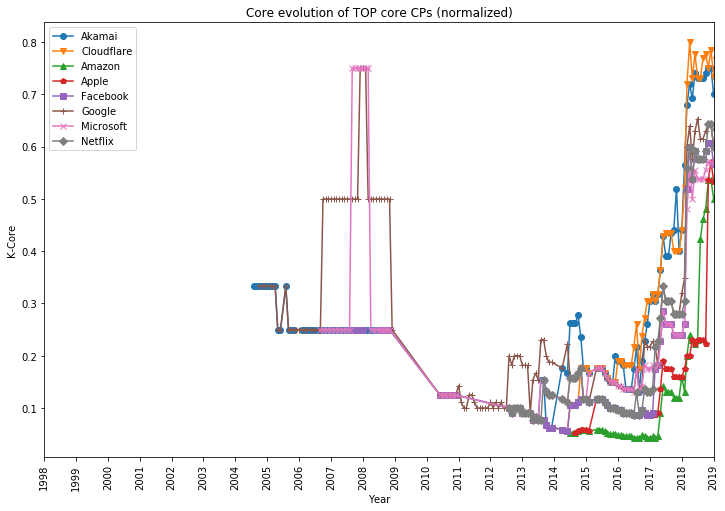

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_core_asns.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_core_asns[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kmax.values, top_core_asns[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of TOP core CPs (normalized)')
plt.legend(loc='best')
plt.savefig('plots/kmax_evolution_africa.png')
plt.show()    

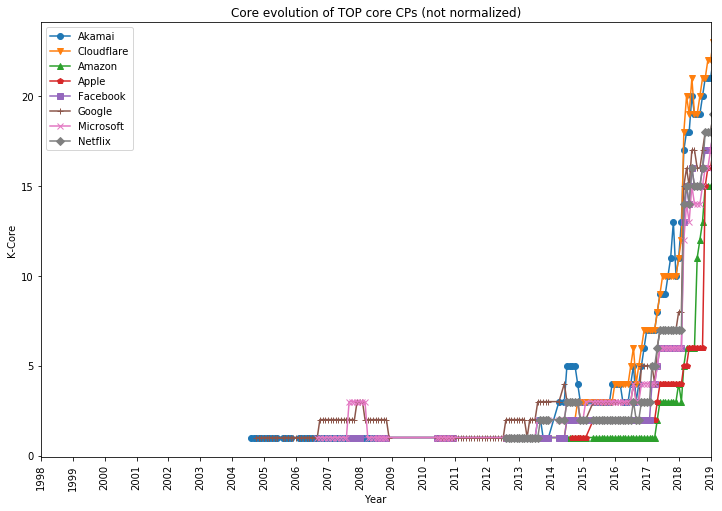

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_core_asns.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_core_asns[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kcore.values, top_core_asns[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of TOP core CPs (not normalized)')
plt.legend(loc='best')
plt.savefig('plots/kcore_africa_evolution.png')
plt.show()    

### Lineplot of normalized kcore value (kmax) - Africa main transit providers
#### based on their out-degree distribution
We select the top 10 African transit providers based on their out-degree distribution

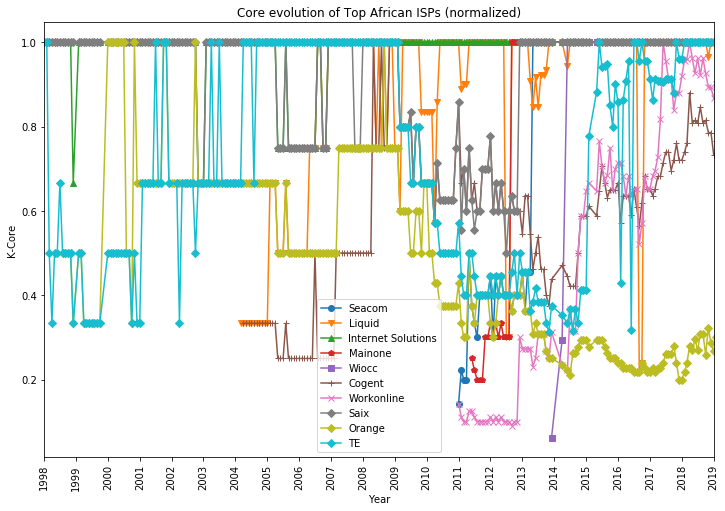

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_africa_asns.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_africa_asns[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kmax.values, top_africa_asns[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of Top African ISPs (normalized)')
plt.legend(loc='best')
plt.savefig('plots/kmax_evolution_africa_main_isps.png')
plt.show()    

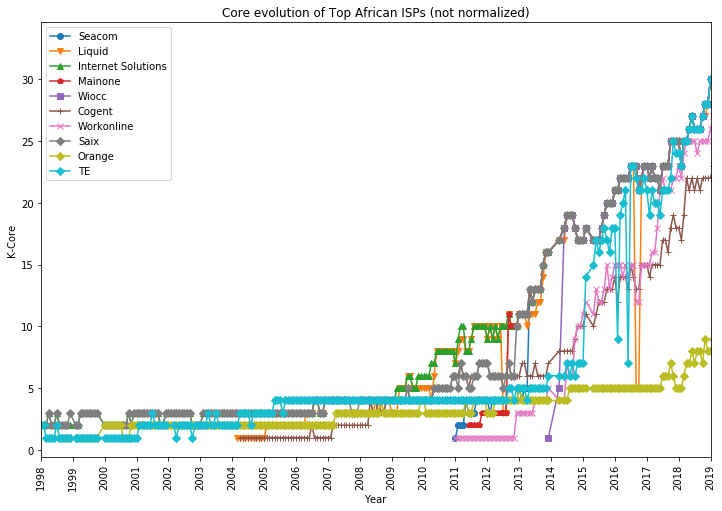

In [32]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_africa_asns.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_africa_asns[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kcore.values, top_africa_asns[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of Top African ISPs (not normalized)')
plt.legend(loc='best')
plt.savefig('plots/kcore_evolution_africa_main_isps.png')
plt.show()    

### Lineplot of normalized kcore value (kmax) - Africa main transit providers
#### TOP CORE only i.e. with ASNs with kmax value as 1
We select the top 10 African transit providers based on their out-degree distribution

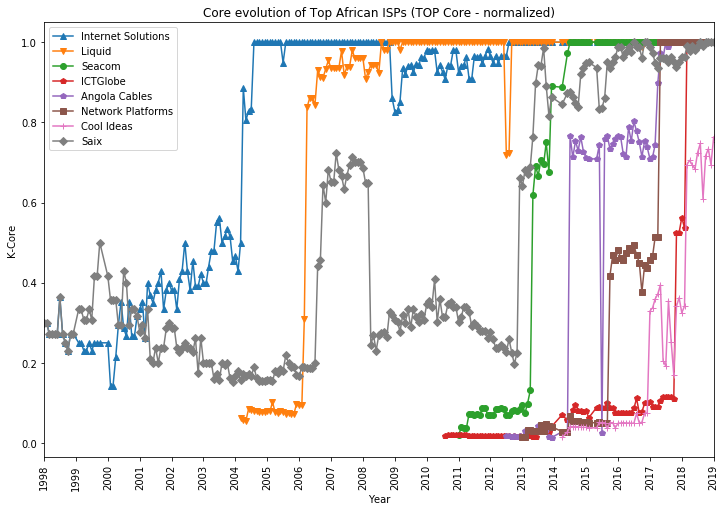

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_kcore_africa.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_kcore_africa[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kmax.values, top_kcore_africa[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of Top African ISPs (TOP Core - normalized)')
plt.legend(loc='best')
plt.savefig('plots/kmax_evolution_africa_top_core.png')
plt.show()    

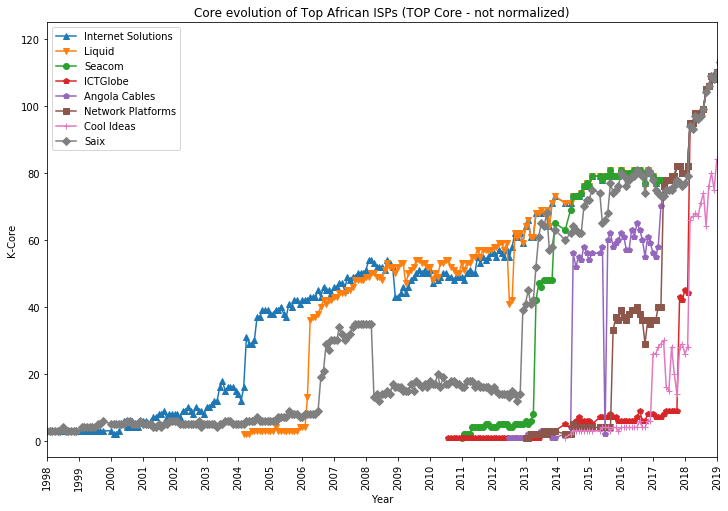

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

for asn in top_kcore_africa.keys():
    data = df_kcore.loc[df_kcore.network == asn].sort_values(by=['date'])
    label = top_kcore_africa[asn][0]
#     ax = data.plot(ax=ax, kind='line', x='date', y='kmax', label=label)
    ax.plot(data.index.values, data.kcore.values, top_kcore_africa[asn][2], label=label)

# Format the x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# # round to nearest years.
datemin = np.datetime64(df_kcore.index.values[0], 'Y')
datemax = np.datetime64(df_kcore.index.values[-1], 'Y') 
ax.set_xlim(datemin, datemax)    

plt.ylabel('K-Core')
plt.xlabel('Year')
plt.xticks(rotation='vertical')

plt.title('Core evolution of Top African ISPs (TOP Core - not normalized)')
plt.legend(loc='best')
plt.savefig('plots/kcore_evolution_africa_top_core.png')
plt.show()    

## Identifying TOP Core networks from the AFRINIC region
We take the latest AS-relationship file from CAIDA

In [308]:
df_kcore_2019 = get_kcore('20190801.as-rel.txt', '2019-08-01')

In [310]:
df_asn_cc = pd.read_csv('data/asn_cc.csv')
df_asn_cc.head()

,network,country_code,seen
0,0,AR,1
1,0,AT,2
2,0,AU,5
3,0,BG,1
4,0,BR,1


In [313]:
df_kcore_2019['cc'] = df_kcore_2019.apply(lambda x: getMaxSeenCC(df_asn_cc, x.network), axis=1)

In [321]:
df_kcore_2019 = df_kcore_2019.loc[df_kcore_2019.cc.isin(ccs)]
df_kcore_2019 = df_kcore_2019.loc[df_kcore_2019.kmax == 1]


In [330]:
df_kcore_2019['category'] = df_kcore_2019.apply(lambda x: top_kcore_africa[x.network][3], axis=1)
df_kcore_2019['name'] = df_kcore_2019.apply(lambda x: top_kcore_africa[x.network][0], axis=1)

,network,kcore,kmax,date,cc,category,name
79,3741,114,1.0,2019-08-01,ZA,DCH,Internet Solutions
203,30844,114,1.0,2019-08-01,KE,ISP,Liquid
220,37100,114,1.0,2019-08-01,KE,DCH,Seacom
222,37239,114,1.0,2019-08-01,ZA,DCH,ICTGlobe
224,37468,114,1.0,2019-08-01,AO,DCH,Angola Cables
226,37497,114,1.0,2019-08-01,ZA,COM,Network Platforms
228,37680,114,1.0,2019-08-01,ZA,ISP,Cool Ideas
749,5713,114,1.0,2019-08-01,CD,ISP/MOB,Saix


In [331]:
df_kcore_2019.iloc[:,[0, 4, 5,6]]

,network,cc,category,name
79,3741,ZA,DCH,Internet Solutions
203,30844,KE,ISP,Liquid
220,37100,KE,DCH,Seacom
222,37239,ZA,DCH,ICTGlobe
224,37468,AO,DCH,Angola Cables
226,37497,ZA,COM,Network Platforms
228,37680,ZA,ISP,Cool Ideas
749,5713,CD,ISP/MOB,Saix
